In [1]:
%matplotlib inline

In [1]:
import logbook
import hyperseti
import numpy as np
from astropy import units as u
import pylab as plt
import cupy as cp
from hyperseti.hyperseti import spectral_kurtosis, sk_flag
hyperseti.logger_group.level = logbook.DEBUG
hyperseti.data.logger.level  = logbook.DEBUG

bshuf filter already loaded, skip it.


In [2]:

# zero drift test, no normalization
noise = np.random.random(size=32*1*512).reshape((32,1,512)) * 2
test_data = np.zeros(shape=(32, 1, 512), dtype='float32')
test_data[:, 0, 255] = 100
test_data[:, 0, 100] = 100*np.sin(4*np.arange(0,32))
test_data += noise**2

metadata = {'fch1': 1000*u.MHz, 
        'dt': 1.0*u.s, 
        'df': 1.0*u.Hz}

dedopp, metadata = hyperseti.dedoppler(test_data, metadata, boxcar_size=1, kernel='kurtosis',
                             max_dd=0)



plt.subplot(2,1,1)
plt.semilogy(dedopp[0])#, aspect='auto')
plt.subplot(2,1,2)
plt.plot(dedopp[0])#, aspect='auto')
plt.ylim(0, 3)

[2021-04-16 10:30:26.672477] INFO: hyperseti.hyperseti: Dedopp setup time: 325.09ms
[2021-04-16 10:30:26.673485] DEBUG: hyperseti.hyperseti: Kernel shape (grid, block) ((1, 1), (512,))
[2021-04-16 10:30:26.674398] DEBUG: hyperseti.hyperseti: rescaling SK by 2
[2021-04-16 10:30:26.675023] DEBUG: hyperseti.hyperseti: driftrates: [0]
[2021-04-16 10:30:26.812435] INFO: hyperseti.hyperseti: Dedopp kernel time: 138.92ms
[2021-04-16 10:30:26.814446] INFO: hyperseti.hyperseti: Dedoppler: copying over to CPU


(0.0, 3.0)

[2021-04-16 09:37:35.033949] INFO: hyperseti.hyperseti: Dedopp setup time: 0.82ms
[2021-04-16 09:37:35.035020] DEBUG: hyperseti.hyperseti: Kernel shape (grid, block) ((1, 1), (512,))
[2021-04-16 09:37:35.036214] DEBUG: hyperseti.hyperseti: rescaling SK by 2
[2021-04-16 09:37:35.037347] DEBUG: hyperseti.hyperseti: driftrates: [0]
[2021-04-16 09:37:35.038660] INFO: hyperseti.hyperseti: Dedopp kernel time: 3.72ms
[2021-04-16 09:37:35.039341] INFO: hyperseti.hyperseti: Dedoppler: copying over to CPU


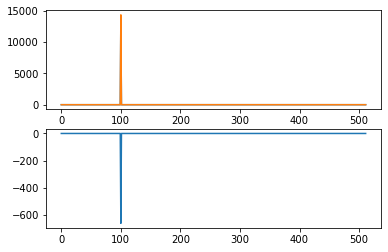

In [24]:
import numpy as np
from astropy import units as u

def sk_cpu(x, N=1):
    x_sum = x.sum(axis=0)
    x2_sum = (x**2).sum(axis=0)
    n = x.shape[0]
    return (N*n+1) / (n-1) * (n*(x2_sum / (x_sum*x_sum)) - 1)

# zero drift test, no normalization
noise = np.random.random(size=32*1*512).reshape((32,1,512)) * 2
test_data = np.zeros(shape=(32, 1, 512), dtype='float32')
test_data[:, 0, 255] = 100
test_data[:, 0, 100] = 100*np.sin(4*np.arange(0,32))
test_data += noise**2


metadata = {'fch1': 1000*u.MHz, 
        'dt': 1.0*u.s, 
        'df': 1.0*u.Hz}


sk = spectral_kurtosis(test_data, metadata)
skc = sk_cpu(test_data.squeeze(), N=2)

plt.subplot(2,1,1)
plt.plot(sk)
plt.plot(skc)
plt.subplot(2,1,2)
plt.plot(sk - skc)


[2021-04-16 09:41:27.715198] INFO: hyperseti.hyperseti: Dedopp setup time: 0.54ms
[2021-04-16 09:41:27.715927] DEBUG: hyperseti.hyperseti: Kernel shape (grid, block) ((1, 65), (512,))
[2021-04-16 09:41:27.717018] DEBUG: hyperseti.hyperseti: rescaling SK by 2
[2021-04-16 09:41:27.717894] DEBUG: hyperseti.hyperseti: driftrates: [-32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15
 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3
   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  32]
[2021-04-16 09:41:27.718607] INFO: hyperseti.hyperseti: Dedopp kernel time: 2.71ms
[2021-04-16 09:41:27.719795] INFO: hyperseti.hyperseti: Dedoppler: copying over to CPU


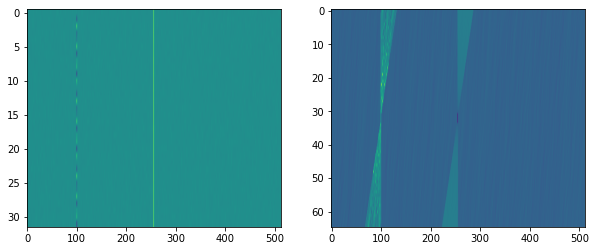

In [26]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.imshow(test_data.squeeze(), aspect='auto')

dedopp, metadata = hyperseti.dedoppler(test_data, metadata, boxcar_size=1, kernel='kurtosis',
                             max_dd=1.0)
plt.subplot(1,2,2)
plt.imshow(np.log(dedopp), aspect='auto')

[2021-04-16 08:40:25.379076] INFO: hyperseti.hyperseti: Dedopp setup time: 1.06ms
[2021-04-16 08:40:25.379891] DEBUG: hyperseti.hyperseti: Kernel shape (grid, block) ((1, 65), (512,))
[2021-04-16 08:40:25.381012] DEBUG: hyperseti.hyperseti: rescaling SK by 2
[2021-04-16 08:40:25.382008] DEBUG: hyperseti.hyperseti: driftrates: [-32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15
 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3
   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  32]
[2021-04-16 08:40:25.383290] INFO: hyperseti.hyperseti: Dedopp kernel time: 3.47ms
[2021-04-16 08:40:25.384073] INFO: hyperseti.hyperseti: Dedoppler: copying over to CPU


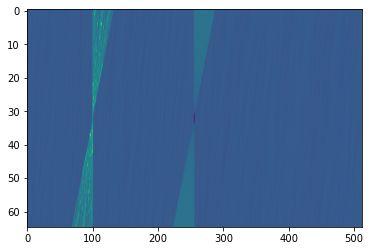

### real data

In [5]:
from hyperseti.data import from_h5
d_h5 = from_h5('/home/dancpr/blimpy/tests/test_data/Voyager1.single_coarse.fine_res.h5')

In [6]:
d = d_h5.data[:]

metadata = {}
metadata['df'] = np.abs(d_h5.frequency.val_step * u.MHz)
metadata['dt'] = np.abs(d_h5.time.val_step * u.s)
metadata['fch1'] = d_h5.frequency.val_start * u.MHz

D = d[:, :, 16384:16384+16384]
plt.imshow(D.squeeze(), aspect='auto')

sk = spectral_kurtosis(D, metadata, boxcar_size=1)

def sk_cpu(x, N=1):
    x_sum = x.sum(axis=0)
    x2_sum = (x**2).sum(axis=0)
    n = x.shape[0]
    return N*(n+1) / (n-1) * (n*(x2_sum / (x_sum*x_sum)) - 1)

skc = sk_cpu(D.squeeze(), N=102)

print(f"MEAN {np.mean(sk):2.3f} STD {np.std(sk)}")
print(f"MEAN {np.mean(skc):2.3f} STD {np.std(skc)}")

[2021-04-16 09:20:49.511651] INFO: hyperseti.hyperseti: Dedopp setup time: 3856.69ms
[2021-04-16 09:20:49.513400] DEBUG: hyperseti.hyperseti: Kernel shape (grid, block) ((16, 1), (1024,))
[2021-04-16 09:20:49.514763] DEBUG: hyperseti.hyperseti: rescaling SK by 102
[2021-04-16 09:20:49.515607] DEBUG: hyperseti.hyperseti: driftrates: [0]
[2021-04-16 09:20:49.655191] INFO: hyperseti.hyperseti: Dedopp kernel time: 141.91ms
[2021-04-16 09:20:49.656006] INFO: hyperseti.hyperseti: Dedoppler: copying over to CPU
MEAN 1.085 STD 0.4021848440170288
MEAN 1.161 STD 0.4265289604663849


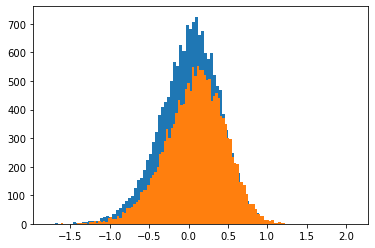

In [16]:
z = plt.hist(np.log(sk), bins=100)
z = plt.hist(np.log(skc), bins=100)

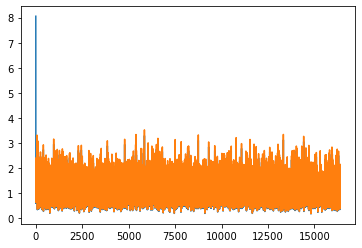

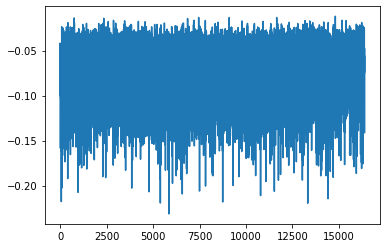

In [17]:
plt.plot(sk)
plt.plot(skc)
plt.figure()
plt.plot(sk[1:]-skc[1:])

[2021-04-16 08:58:27.051825] INFO: hyperseti.hyperseti: Dedopp setup time: 11.97ms
[2021-04-16 08:58:27.053063] DEBUG: hyperseti.hyperseti: Kernel shape (grid, block) ((1024, 1), (1024,))
[2021-04-16 08:58:27.054223] DEBUG: hyperseti.hyperseti: rescaling SK by 102
[2021-04-16 08:58:27.055091] DEBUG: hyperseti.hyperseti: driftrates: [0]
[2021-04-16 08:58:27.055892] INFO: hyperseti.hyperseti: Dedopp kernel time: 2.92ms
[2021-04-16 08:58:27.057061] INFO: hyperseti.hyperseti: Dedoppler: copying over to CPU


In [112]:
import cupy as cp

In [4]:
mask = sk_flag(d, metadata, n_sigma_lower=2, n_sigma_upper=5, flag_upper=True, flag_lower=True)
dma = np.ma.array(d.mean(axis=0)).squeeze()
dma.mask = mask
n = np.ma.array(np.arange(dma.shape[0]))
n.mask = mask

NameError: name 'd' is not defined

In [131]:
d_gpu = cp.asarray(d)
mask_gpu = cp.repeat(cp.asarray(mask), d_gpu.shape[0]).reshape(d_gpu.shape)
cp.putmask(d_gpu, mask_gpu, 0)

[2021-04-16 05:45:07.191335] INFO: hyperseti.hyperseti: Dedopp setup time: 79.43ms
[2021-04-16 05:45:07.195822] DEBUG: hyperseti.hyperseti: Kernel shape (grid, block)
[2021-04-16 05:45:07.199119] DEBUG: hyperseti.hyperseti: rescaling SK by 102
[2021-04-16 05:45:07.201002] DEBUG: hyperseti.hyperseti: driftrates: [0]
[2021-04-16 05:45:07.202086] INFO: hyperseti.hyperseti: Dedopp kernel time: 6.38ms
[2021-04-16 05:45:07.203170] INFO: hyperseti.hyperseti: Dedoppler: copying over to CPU


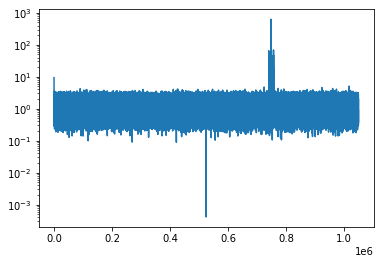

In [34]:
sk = spectral_kurtosis(d_h5.data[:], metadata, boxcar_size=1)
mask = sk > 1 + var
plt.semilogy(sk)

In [9]:
mask = sk_flag(d, metadata, n_sigma_lower=2, n_sigma_upper=5, flag_upper=True, flag_lower=True)
d = d_h5.data[:].astype('float32')

d_gpu = cp.asarray(d)
d_norm = hyperseti.normalize(d_gpu)

mask_gpu = cp.repeat(cp.asarray(mask), d_gpu.shape[0]).reshape(d_gpu.shape)
print(f"")
cp.putmask(d_gpu, mask_gpu, 0)

d_norm_masked = hyperseti.normalize(d_gpu)

pad = 50000
print(f"{d_norm[..., pad:-pad].std()}, {d_norm_masked[..., pad:-pad].std()}")

[2021-04-16 09:21:06.952415] INFO: hyperseti.hyperseti: Dedopp setup time: 21.87ms
[2021-04-16 09:21:06.953589] DEBUG: hyperseti.hyperseti: Kernel shape (grid, block) ((1024, 1), (1024,))
[2021-04-16 09:21:06.954734] DEBUG: hyperseti.hyperseti: rescaling SK by 102
[2021-04-16 09:21:06.955582] DEBUG: hyperseti.hyperseti: driftrates: [0]
[2021-04-16 09:21:06.956357] INFO: hyperseti.hyperseti: Dedopp kernel time: 2.87ms
[2021-04-16 09:21:06.957122] INFO: hyperseti.hyperseti: Dedoppler: copying over to CPU
[2021-04-16 09:21:07.519439] INFO: hyperseti.hyperseti: Normalisation time: 303.22ms

[2021-04-16 09:21:14.443314] INFO: hyperseti.hyperseti: Normalisation time: 0.68ms
1.0510542392730713, 1.0510534048080444


In [10]:
np.max(d_norm_masked)

1027.3982

In [14]:
np.argmax(d.mean(axis=0))

524288

In [2]:
import setigen as stg

metadata = {'fch1': 6095.214842353016*u.MHz, 
            'dt': 18.25361108*u.s , 
            'df': 2.7939677238464355*u.Hz}

frame = stg.Frame(fchans=2**12*u.pixel,
                  tchans=32*u.pixel,
                  df=metadata['df'],
                  dt=metadata['dt'],
                  fch1=metadata['fch1'])

test_tones = [
  {'f_start': frame.get_frequency(index=500), 'drift_rate': 0.50*u.Hz/u.s, 'snr': 10000, 'width': 20*u.Hz},
  {'f_start': frame.get_frequency(index=800), 'drift_rate': -0.40*u.Hz/u.s, 'snr': 100, 'width': 20*u.Hz},
  {'f_start': frame.get_frequency(index=2048), 'drift_rate': 0.00*u.Hz/u.s, 'snr': 200, 'width': 6*u.Hz},
  {'f_start': frame.get_frequency(index=3000), 'drift_rate': 0.07*u.Hz/u.s, 'snr': 500, 'width': 3*u.Hz}
]

noise = frame.add_noise(x_mean=10, x_std=5, noise_type='chi2')

for tone in test_tones:
    signal = frame.add_signal(stg.constant_path(f_start=tone['f_start'],
                                            drift_rate=tone['drift_rate']),
                          stg.constant_t_profile(level=frame.get_intensity(snr=tone['snr'])),
                          stg.gaussian_f_profile(width=tone['width']),
                          stg.constant_bp_profile(level=1))

In [3]:
%matplotlib inline

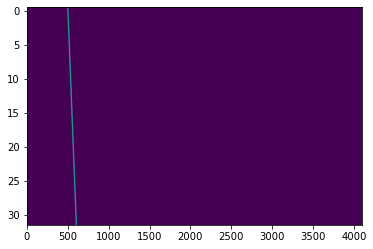

In [4]:
plt.imshow(frame.data, aspect='auto')

[2021-04-16 10:45:15.282665] INFO: hyperseti.hyperseti: Dedopp setup time: 1.59ms
[2021-04-16 10:45:15.283727] DEBUG: hyperseti.hyperseti: Kernel shape (grid, block) ((4, 1), (1024,))
[2021-04-16 10:45:15.284956] DEBUG: hyperseti.hyperseti: rescaling SK by 102
[2021-04-16 10:45:15.285824] DEBUG: hyperseti.hyperseti: driftrates: [0]
[2021-04-16 10:45:15.286696] INFO: hyperseti.hyperseti: Dedopp kernel time: 3.08ms
[2021-04-16 10:45:15.287964] INFO: hyperseti.hyperseti: Dedoppler: copying over to CPU
MEAN 25.574 STD 142.73887634277344
[2021-04-16 10:45:15.329364] DEBUG: hyperseti.hyperseti: flag fraction correction factor: 1.0
[2021-04-16 10:45:15.330122] INFO: hyperseti.hyperseti: Normalisation time: 1.20ms
[2021-04-16 10:45:15.331777] INFO: hyperseti.hyperseti: Dedopp setup time: 0.39ms
[2021-04-16 10:45:15.332271] DEBUG: hyperseti.hyperseti: Kernel shape (grid, block) ((4, 1), (1024,))
[2021-04-16 10:45:15.333117] DEBUG: hyperseti.hyperseti: rescaling SK by 102
[2021-04-16 10:45:15.33

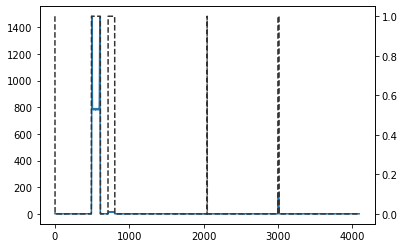

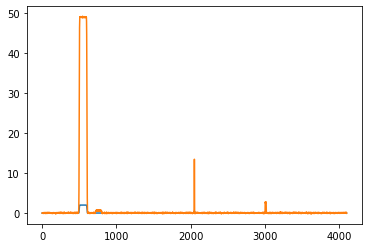

In [6]:
sk = spectral_kurtosis(frame.data.reshape((32, 1, 4096)), metadata, boxcar_size=1)
print(f"MEAN {np.mean(sk):2.3f} STD {np.std(sk)}")

plt.plot(sk)
plt.twinx()
d = frame.data.reshape((32, 1, 4096))
d_norm = hyperseti.normalize(d)

mask = hyperseti.hyperseti.sk_flag(d, metadata, n_sigma_lower=2, n_sigma_upper=5, flag_upper=True, flag_lower=True)
d_norm_flagged = hyperseti.normalize(d, mask)

plt.plot(mask, ls='dashed', color='#333333')
plt.figure()
plt.plot(d_norm.mean(axis=0).squeeze())
plt.plot(d_norm_flagged.mean(axis=0).squeeze())
#plt.ylim(-1,1)



In [9]:
np.std(d_norm_flagged)

24.341849822232604

In [25]:
a = cp.array([[1,2,3,4],])
cp.repeat(a, 4, axis=0)

array([[1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4]])

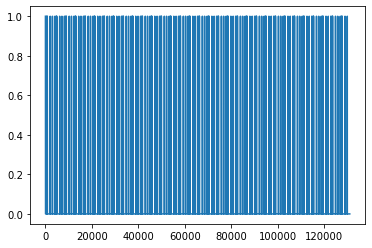

In [28]:
plt.plot(cp.asnumpy(cp.repeat(cp.asarray(mask.reshape((1, len(mask)))), d_norm.shape[0], axis=0)).ravel())

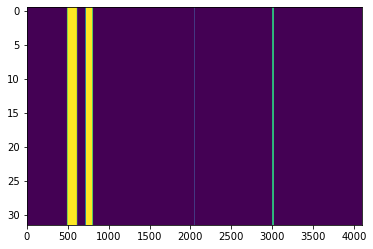

In [37]:
df =cp.asarray(d_norm)
mask_gpu = cp.repeat(cp.asarray(mask.reshape(1, 1, len(mask))), d_norm.shape[0], axis=0)
cp.putmask(df, mask_gpu, 0)
#plt.imshow(cp.asnumpy(df).squeeze(), aspect='auto')
plt.imshow(cp.asnumpy(mask_gpu).squeeze(), aspect='auto')

[2021-04-16 09:41:51.011444] INFO: hyperseti.hyperseti: Dedopp setup time: 0.73ms
[2021-04-16 09:41:51.012213] DEBUG: hyperseti.hyperseti: Kernel shape (grid, block) ((4, 1), (1024,))
[2021-04-16 09:41:51.013303] DEBUG: hyperseti.hyperseti: rescaling SK by 102
[2021-04-16 09:41:51.014111] DEBUG: hyperseti.hyperseti: driftrates: [0]
[2021-04-16 09:41:51.015269] INFO: hyperseti.hyperseti: Dedopp kernel time: 3.10ms
[2021-04-16 09:41:51.015902] INFO: hyperseti.hyperseti: Dedoppler: copying over to CPU
MEAN 1.004 STD 0.26155322790145874


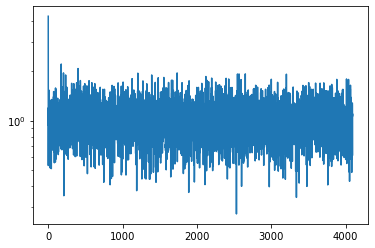

In [31]:
metadata = {'fch1': 1000.0*u.MHz, 
            'dt': 18.25361108*u.s, 
            'df': 2.7939677238464355*u.Hz}

N_chan, N_time = 2**12, 32

frame = stg.Frame(fchans=N_chan*u.pixel,
                  tchans=N_time*u.pixel,
                  df=metadata['df'],
                  dt=metadata['dt'],
                  fch1=metadata['fch1'])

noise = frame.add_noise(x_mean=100, x_std=50, noise_type='chi2')
sk = spectral_kurtosis(noise.reshape((N_time, 1, N_chan)), metadata, boxcar_size=1)
print(f"MEAN {np.mean(sk):2.3f} STD {np.std(sk)}")

plt.semilogy(sk)

[2021-04-16 05:16:47.037400] INFO: hyperseti.hyperseti: Dedopp setup time: 2.85ms
[2021-04-16 05:16:47.038555] DEBUG: hyperseti.hyperseti: Kernel shape (grid, block)
[2021-04-16 05:16:47.039710] DEBUG: hyperseti.hyperseti: rescaling SK by 102
[2021-04-16 05:16:47.041040] INFO: hyperseti.hyperseti: Dedopp kernel time: 2.56ms
[2021-04-16 05:16:47.041711] INFO: hyperseti.hyperseti: Dedoppler: copying over to CPU
MEAN 1.008 STD 0.1257437486730842
MEAN 1.003 STD 0.12568430602550507


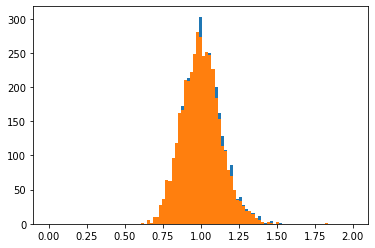

In [45]:
def sk_cpu(x, N=1):
    x_sum = x.sum(axis=0)
    x2_sum = (x**2).sum(axis=0)
    n = x.shape[0]
    return N*(n+1) / (n-1) * (n*(x2_sum / (x_sum*x_sum)) - 1)

sk = sk_cpu(noise, N=102)
sk2 = spectral_kurtosis(noise.reshape((128, 1, 2**12)), metadata, boxcar_size=1)
print(f"MEAN {np.mean(sk):2.3f} STD {np.std(sk)}")
print(f"MEAN {np.mean(sk2):2.3f} STD {np.std(sk2)}")

z = plt.hist(sk, bins=np.linspace(0, 2, 100))
z = plt.hist(sk2, bins=np.linspace(0, 2, 100))

In [46]:
2./np.sqrt(102)

0.19802950859533489

In [127]:
fs

<Quantity 0.17895697 s>